In [1]:
#!pip install tensorflow-gpu

In [2]:
#!pip install tensorflow_addons

In [3]:
import random
import numpy as np
import tensorflow.keras
#import wandb
#from wandb.keras import WandbCallback
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input, Conv2D, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

from tensorflow.keras import applications

from tensorflow.keras.preprocessing import image
import os

import re

Number of Cat images -  166
subject15.happy


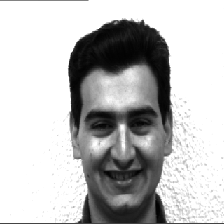

In [4]:
#http://vision.ucsd.edu/content/yale-face-database
img_dir = "../data/yalefaces/"
faceImages = os.listdir(img_dir)
print("Number of Cat images - ",str(len(faceImages)))
print(faceImages[1])

#img_path = 'elephant.jpg'
img = image.load_img(img_dir + faceImages[1], target_size=(224, 224))
x = image.img_to_array(img)

img

In [5]:
x.shape

(224, 224, 3)

In [6]:
x_train = np.zeros((len(faceImages), 224, 224, 3))
y_train = np.empty((len(faceImages),), dtype=np.object_)
for i, face in enumerate(faceImages):
    img = image.load_img(img_dir + face, target_size=(224, 224))
    x = image.img_to_array(img)
    y = face[ : face.index('.')]
    x_train[i] = x
    y_train[i] = y
    
print(x_train.shape)
print(y_train.shape)

(166, 224, 224, 3)
(166,)


In [7]:
y_train

array(['subject09', 'subject15', 'subject15', 'subject01', 'subject07',
       'subject06', 'subject01', 'subject07', 'subject01', 'subject06',
       'subject11', 'subject08', 'subject02', 'subject03', 'subject11',
       'subject15', 'subject15', 'subject15', 'subject13', 'subject03',
       'subject06', 'subject05', 'subject13', 'subject12', 'subject13',
       'subject15', 'subject08', 'subject01', 'subject01', 'subject03',
       'subject07', 'subject07', 'subject08', 'subject09', 'subject02',
       'subject05', 'subject09', 'subject04', 'subject01', 'subject10',
       'subject12', 'subject04', 'subject14', 'subject02', 'subject09',
       'subject15', 'subject06', 'subject10', 'subject10', 'subject15',
       'subject03', 'subject13', 'subject09', 'subject10', 'subject01',
       'subject13', 'subject05', 'subject10', 'subject01', 'subject14',
       'subject06', 'subject13', 'subject08', 'subject01', 'subject03',
       'subject01', 'subject14', 'subject01', 'subject02', 'subj

In [8]:
np.where(y_train == 'subject05')

(array([ 21,  35,  56,  78,  91,  96,  98, 110, 115, 132, 160]),)

In [9]:
y_train[8]

'subject01'

In [10]:
np.unique(y_train)

array(['subject01', 'subject02', 'subject03', 'subject04', 'subject05',
       'subject06', 'subject07', 'subject08', 'subject09', 'subject10',
       'subject11', 'subject12', 'subject13', 'subject14', 'subject15'],
      dtype=object)

In [11]:
random.choice([1,2,3,1,3,4,3,2,2,3,3,3])

3

In [12]:
random.randint(0, 9)

7

In [13]:
# make pairs
def make_pairs(x, y):
    classes = np.unique(y_train)
    num_classes = len(classes)
    
    face_indices_dict = {cls:np.where(y == cls)[0] for cls in classes}
    #print(face_indices_dict)
    #print(digit_indices)
    #print('len *****', len(digit_indices))
    #print('3 digit array', digit_indices[3])
    
    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        for _ in range(10):
            idx2 = random.choice(face_indices_dict[label1])
            x2 = x[idx2]
            pairs += [[x1, x2]]
            labels += [1]
    
        # add a not matching example
        other_labels = [cls for cls in classes if cls not in [label1]]
        
        label2 = random.choice(other_labels)

        for _ in range(10):
        #print(label1, ' --- ', label2)    
            idx2 = random.choice(face_indices_dict[label2])
            x2 = x[idx2]
            pairs += [[x1, x2]]
            labels += [0]

    return np.array(pairs), np.array(labels)

pairs_train, labels_train = make_pairs(x_train, y_train)
#pairs_test, labels_test = make_pairs(x_test, y_test)

In [14]:
x_train.shape

(166, 224, 224, 3)

In [15]:
pairs_train.shape

(3320, 2, 224, 224, 3)

In [16]:
labels_train.shape

(3320,)

In [17]:
pairs_train[0,0,:].shape

(224, 224, 3)

In [18]:
def showPic(pixels):
    image = pixels/np.amax(pixels)
    image = np.clip(image, 0, 1)
    plt.imshow(image)

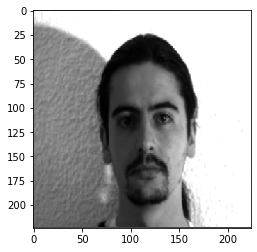

In [19]:
# take a peek at the data
showPic(pairs_train[0,0,:])

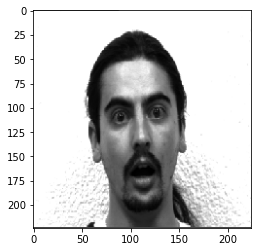

In [20]:
showPic(pairs_train[0,1,:])

In [21]:
labels_train[0]

1

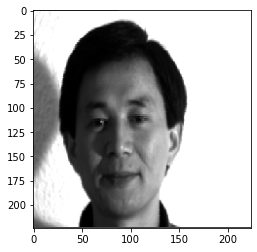

In [22]:
showPic(pairs_train[119,0,:])

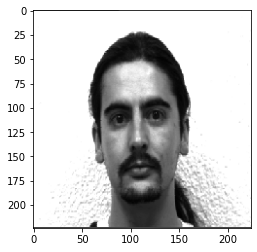

In [23]:
showPic(pairs_train[119,1,:])

In [24]:
labels_train[119]

0

In [25]:
pairs_train = pairs_train/np.max(pairs_train)

In [26]:
import tensorflow_addons as tfa
from tensorflow.keras import backend as K

In [27]:
inputs = Input(shape=(224, 224, 3), name='inputs')

conv1 = Conv2D(activation=K.relu, filters=6, padding='same', kernel_size=10, name='conv1')(inputs)
conv2 = Conv2D(activation=K.relu, filters=6, kernel_size=10, name='conv2')(conv1)
max2 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv2)

conv3 = Conv2D(activation=K.relu, filters=12, padding='same', kernel_size=10, name='conv3')(max2)
conv4 = Conv2D(activation=K.relu, filters=12, kernel_size=10, name='conv4')(conv3)
max4 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv4)

conv5 = Conv2D(activation=K.relu, filters=24, padding='same', kernel_size=10, name='conv5')(max4)
conv6 = Conv2D(activation=K.relu, filters=24, kernel_size=10, name='conv6')(conv5)
max6 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv6)

conv7 = Conv2D(activation=K.relu, filters=48, padding='same', kernel_size=10, name='conv7')(max6)
conv8 = Conv2D(activation=K.relu, filters=48, kernel_size=10, name='conv8')(conv7)
max8 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv8)

flat = Flatten()(max8)

dense1 = Dense(256, activation=K.relu)(flat)

dense2 = Dense(128, activation=K.relu)(dense1)

face_encoder_model = Model(inputs=inputs, outputs=dense2)

In [28]:
face_encoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 224, 224, 6)       1806      
_________________________________________________________________
conv2 (Conv2D)               (None, 215, 215, 6)       3606      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 107, 107, 6)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 107, 107, 12)      7212      
_________________________________________________________________
conv4 (Conv2D)               (None, 98, 98, 12)        14412     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 12)        0     

In [29]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon())) # sum_square come as zero 

input_anchor_face = Input(shape=(224, 224, 3))
input_pos_or_neg_face = Input(shape=(224, 224, 3))

anchor_siamese_net = face_encoder_model(input_anchor_face)
pos_or_neg_siamese_net = face_encoder_model(input_pos_or_neg_face)

merge_layer = Lambda(euclidean_distance)([anchor_siamese_net, pos_or_neg_siamese_net])

sigmoid_layer = Dense(1, activation="sigmoid")(merge_layer)

model = Model(inputs=[input_anchor_face, input_pos_or_neg_face], outputs=sigmoid_layer)

In [30]:
optimizer = RMSprop(learning_rate=0.0001)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128)          799532      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

In [31]:
pairs_train[:,0].shape

(3320, 224, 224, 3)

In [32]:
pairs_train[:,1].shape

(3320, 224, 224, 3)

In [33]:
model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=32, epochs=5)

Epoch 1/5
104/104 [==============================] - 18s 130ms/step - loss: 0.6937 - accuracy: 0.4314
Epoch 2/5
104/104 [==============================] - 11s 109ms/step - loss: 0.6932 - accuracy: 0.4810
Epoch 3/5
104/104 [==============================] - 11s 109ms/step - loss: 0.6931 - accuracy: 0.4992
Epoch 4/5
104/104 [==============================] - 11s 109ms/step - loss: 0.6932 - accuracy: 0.4898
Epoch 5/5
104/104 [==============================] - 12s 112ms/step - loss: 0.6931 - accuracy: 0.4996


In [34]:
face_encoder_model.save("face_encoder_model_custom.h5")

In [35]:
face_encoder_model = tensorflow.keras.models.load_model("face_encoder_model_custom.h5")

In [36]:
encoded_face = face_encoder_model.predict(pairs_train[119,1,:].reshape(1, 224, 224, 3))

In [37]:
encoded_face.shape

(1, 128)

In [38]:
encoded_face

array([[0.00069559, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.0005263 , 0.        , 0.        , 0.        ,
        0.00031833, 0.        , 0.        , 0.        , 0.00089411,
        0.        , 0.        , 0.00022079, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00087099, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00112444, 0.00050016,
        0.        , 0.        , 0.        , 0.        , 0.00050347,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00115   , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00111572,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00140891, 0.        , 0.00072213, 0.        ,
        0.        , 0.        , 0.        , 0.  

* https://github.com/Ekeany/Siamese-Network-with-Triplet-Loss/blob/master/MachinePart1.ipynb

Kaggle - Challenges in Representation Learning: Facial Expression Recognition Challenge
  * https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/discussion
  * https://www.youtube.com/watch?v=DtBu1u5aBsc

Sliding Window Classifier: Rain Drop Detection
  * https://github.com/tobybreckon/raindrop-detection-cnn/blob/master/raindrop_detection_sliding_window.py

Convolutional implementation of the sliding window algorithm
  * https://medium.com/ai-quest/convolutional-implementation-of-the-sliding-window-algorithm-db93a49f99a0